In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.spatial.distance
import csv
#import dask.dataframe as dd

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#Require a pandas version lower than the latest as the latest doesn't allow for indexing beyond size int32
pd.__version__

'0.25.1'

## Read in the sparse data - don't run this

In [ ]:
df = pd.read_csv('/Volumes/external/Sangeetha-Project/Original files/book_reviews.csv.zip',
                 names=['reviewerId', 'asin', 'review', 'rating',
                        'summary', 'unixtime', 'pos_votes', 'total_votes']) \
    .drop(columns=['review'])\
    .astype({'rating': 'int8', 'total_votes': 'int32', 'pos_votes': 'int32'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728360 entries, 0 to 2728359
Data columns (total 5 columns):
reviewerId     object
asin           object
rating         int8
summary        object
total_votes    int32
dtypes: int32(1), int8(1), object(3)
memory usage: 75.5+ MB


In [7]:
df.head()

,reviewerId,asin,rating,summary,total_votes
0,A10000012B7CGYKOMPQ4L,000100039X,5,Wonderful!,0
1,A2S166WSCFIFP5,000100039X,5,close to god,2
2,A1MOSTXNIO5MPJ,000100039X,5,Timeless for every good and bad time in your l...,0
3,A2XQ5LZHTD4AFT,000100039X,5,A Modern Rumi,9
4,A3V1MKC2BVWY48,000100039X,5,This book will bring you peace,0


In [8]:
print(len(df.reviewerId.unique()))
print(len(df.asin.unique()))

306101
92244


## Cutting the dataset down - don't run this

The kernel keep dying with the original 2,728,360 rows, with 306,101 reviewers and 92,244 books, due a memory error. So I decided to condense the dataset down a little more. The new dataset has 1,079,183 rows with 86,641 reviewers and 17,557 books and much easier for my laptop to handle. 

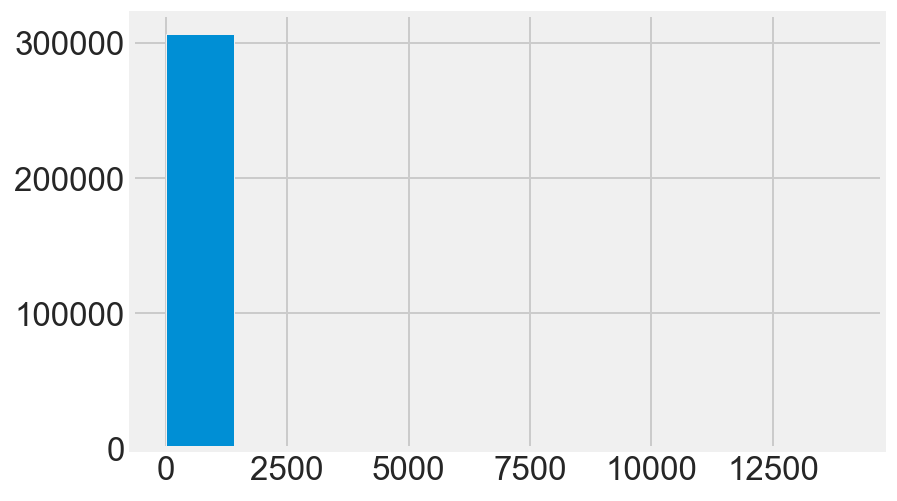

In [9]:
df.reviewerId.value_counts().hist()
plt.show()

In [10]:
asin_counts = df.asin.value_counts()

In [11]:
df_sub = df[df.asin.isin(asin_counts[asin_counts>50].index)]

In [12]:
review_counts = df_sub.reviewerId.value_counts()

In [13]:
df_sub = df_sub[df_sub.reviewerId.isin(review_counts[review_counts>50].index)]

In [14]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273661 entries, 1 to 2728290
Data columns (total 5 columns):
reviewerId     273661 non-null object
asin           273661 non-null object
rating         273661 non-null int8
summary        273661 non-null object
total_votes    273661 non-null int32
dtypes: int32(1), int8(1), object(3)
memory usage: 9.7+ MB


In [15]:
df_sub.to_csv('/Volumes/external/Sangeetha-Project/df_subx.csv.gz', header=True, index =False, compression='gzip')

## Load the saved dense df

In [3]:
df_sub = pd.read_csv('/Volumes/external/Sangeetha-Project/df_sub.csv.gz', 
                       compression='gzip').astype({'rating':'int8', 'total_votes':'int32'})

In [4]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273661 entries, 0 to 273660
Data columns (total 5 columns):
reviewerId     273661 non-null object
asin           273661 non-null object
rating         273661 non-null int8
summary        273661 non-null object
total_votes    273661 non-null int32
dtypes: int32(1), int8(1), object(3)
memory usage: 7.6+ MB


In [14]:
df_sub.describe()

,rating,total_votes
count,273661.000000,273661.000000
mean,4.089158,7.690533
std,0.986875,41.105538
min,1.000000,0.000000
25%,4.000000,0.000000
50%,4.000000,2.000000
75%,5.000000,5.000000
max,5.000000,5302.000000


In [5]:
df_sub.head()

,reviewerId,asin,rating,summary,total_votes
0,A2S166WSCFIFP5,000100039X,5,close to god,2
1,AWLFVCT9128JV,000100039X,5,The Lessons Of Life,10
2,A2NHD7LUXVGTD3,000100039X,5,a beautiful poetic commentary on what it is to...,1
3,A1K1JW1C5CUSUZ,000100039X,5,Transcend Human Subjectivity to Find Godlike O...,4
4,A38AAPXSJN4C5G,000100039X,5,Inspired and Inspiring,0


In [6]:
print('Reviewers under 5: ', (df_sub.reviewerId.value_counts() < 5).mean())
print('Mean reviewers: ', df_sub.reviewerId.value_counts().mean())
print('Median reviewers: ', df_sub.reviewerId.value_counts().median())
print('-----------------------------------------------')
print('Books under 5: ', (df_sub.asin.value_counts() < 5).mean())
print('Mean books: ', df_sub.asin.value_counts().mean())
print('Median books: ', df_sub.asin.value_counts().median())

Reviewers under 5:  0.0
Mean reviewers:  103.3853418964866
Median reviewers:  78.0
-----------------------------------------------
Books under 5:  0.0804953560371517
Mean books:  24.919049353487527
Median books:  19.0


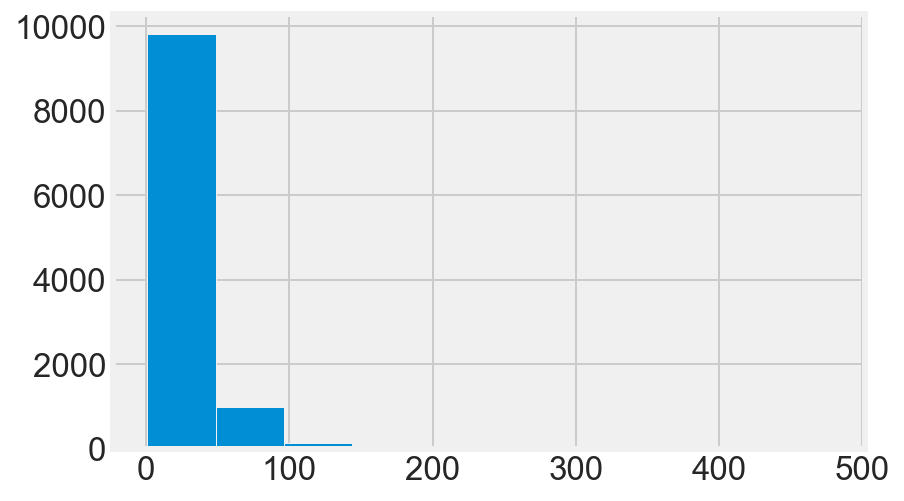

In [7]:
df_sub.asin.value_counts().hist()
plt.show()

## Prediction matrix based on collaborative filtering - baseline only

In [8]:
overall_mean = df_sub.rating.mean()
overall_mean

4.089157753571024

In [9]:
#User bias:
bu = df_sub.groupby('reviewerId')[['rating']].mean() - overall_mean
bu[:5]

,rating
reviewerId,
A100NGGXRQF0AQ,0.156605
A102Z3T7NSM5KC,0.148937
A106016KSI0YQ,-0.417925
A106E1N0ZQ4D9W,0.099248
A10BZSGALQPS0V,-0.145895


In [10]:
#item bias
bi = df_sub.groupby('asin')[['rating']].mean() - overall_mean
bi[:5]

,rating
asin,
000100039X,0.437158
0002007770,0.278872
0002051850,0.300673
0002219417,0.680073
000222383X,0.547206


In [11]:
baseline_est = overall_mean + bu.values.reshape(-1,1) + bi.values.reshape(1,-1)
baseline_est = pd.DataFrame(baseline_est, index = bu.index, columns = bi.index)
baseline_est.head()

asin,000100039X,0002007770,0002051850,0002219417,000222383X,000224053X,0002242052,0002247399,0002550938,0002726874,...,452289858,452295297,452295386,452295513,452295831,452296099,452296293,452296315,452296366,452296544
reviewerId,,,,,,,,,,,,,,,,,,,,,
A100NGGXRQF0AQ,4.682921,4.524635,4.546435,4.925836,4.792969,4.008457,4.549462,3.993814,3.611150,4.792969,...,4.823272,4.734918,3.538958,3.771990,5.156605,3.448272,3.468293,3.299462,4.562855,4.156605
A102Z3T7NSM5KC,4.675253,4.516967,4.538768,4.918168,4.785301,4.000789,4.541795,3.986147,3.603483,4.785301,...,4.815604,4.727251,3.531290,3.764322,5.148937,3.440604,3.460626,3.291795,4.555187,4.148937
A106016KSI0YQ,4.108391,3.950105,3.971906,4.351306,4.218439,3.433927,3.974932,3.419284,3.036621,4.218439,...,4.248742,4.160388,2.964428,3.197460,4.582075,2.873742,2.893763,2.724932,3.988325,3.582075
A106E1N0ZQ4D9W,4.625564,4.467278,4.489079,4.868479,4.735612,3.951100,4.492105,3.936457,3.553793,4.735612,...,4.765915,4.677561,3.481601,3.714633,5.099248,3.390915,3.410936,3.242105,4.505498,4.099248
A10BZSGALQPS0V,4.380420,4.222134,4.243935,4.623335,4.490468,3.705957,4.246962,3.691314,3.308650,4.490468,...,4.520771,4.432418,3.236458,3.469489,4.854105,3.145771,3.165793,2.996962,4.260355,3.854105


In [12]:
baseline_est.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, A100NGGXRQF0AQ to AZY96LU53VWGO
Columns: 10982 entries, 000100039X to 452296544
dtypes: float64(10982)
memory usage: 221.8+ MB


In [15]:
baseline_est[baseline_est>5] = 5
baseline_est[baseline_est<1] = 1

In [5]:
baseline_est.to_csv('/Volumes/external/Sangeetha-Project/baseline_est-.csv.gz', header = True, index=True,
                       compression='gzip')

NameError: name 'baseline_est' is not defined

## Running through an example - user 100 ('A151OW029XD9JU') & book 4599 (0312385846)

In [7]:
baseline_est = pd.read_csv('/Volumes/external/Sangeetha-Project/baseline_est.csv.gz', index_col=0,
                       compression='gzip')

In [9]:
df_sub = pd.read_csv('/Volumes/external/Sangeetha-Project/df_sub.csv.gz', 
                       compression='gzip').astype({'rating':'int8', 'total_votes':'int32'})

In [61]:
#Pick a random user:
#user=random.choice(np.unique(df_sub.reviewerId))
user = 'A2S166WSCFIFP5'
user

'A2S166WSCFIFP5'

In [62]:
#Create a list of unread books with more than 10 reviews
books_over_10_reviews = df_sub.asin.value_counts()
books_over_10_reviews= np.array(books_over_10_reviews[books_over_10_reviews>10].index)
books_over_10_reviews[:5]

array(['0439023483', '0143170090', '030758836X', '0439023513',
       '0141039280'], dtype=object)

In [63]:
books_read_by_user = df_sub[df_sub.reviewerId == user].asin.values
books_read_by_user[:5]

array(['000100039X', '0007136838', '0020519001', '0020519109',
       '006000942X'], dtype=object)

In [64]:
#Books that have over 10 reviews but hasnt been read by user
unread_book_by_user= [x for x in books_over_10_reviews if x not in books_read_by_user]
unread_book_by_user[:5]

['0439023483', '0143170090', '030758836X', '0439023513', '0141039280']

In [79]:
book_chosen = random.choice(unread_book_by_user)
#book_chosen = '0312385846'
book_chosen = '0002007770'

In [80]:
#Check to see if the reviewer hasnt read the book yet if you want 
df_sub[(df_sub.reviewerId==user)&(df_sub.asin==book_chosen)]

,reviewerId,asin,rating,summary,total_votes


In [81]:
#List of users who have rated the book
reviewers_rated_book = df_sub[df_sub.asin==book_chosen].reviewerId.values
reviewers_rated_book

array(['APBA7Y4SINS0H', 'A22019GDU7OVFG', 'A1HRYC60VTMYC0',
       'A1QZ6MFP9TSQU6', 'A3T4KN9XO3PIXG', 'A19D3N662QS9WD',
       'A26UNIPEVYE9DE', 'A914TQVHI872U', 'A3E02KBFI21TY0',
       'A3BIWTN2DA0YY2', 'A30H2335OM7RD6', 'A21NVBFIEQWDSG',
       'AJQ1S39GZBKUG', 'A2PN65B6BSTIYZ', 'A3KOO6L0NA2PJA',
       'A3GUK4RWXKHS9I', 'ASPABROV8R7M5', 'A75W6T9I2S8BA',
       'A33E0CODNP98PV', 'A3QVI57VT1VGRO', 'A5H86XYSS0OU6',
       'A2PWUIQG57O1AZ', 'AK536TCZST9B', 'A26BVUB2YJMGB7',
       'A2ATWKOFJXRRR1', 'A1PKJUAQFGNLSX', 'A15NZD5WINDQZM',
       'A39650P2CZUUC9', 'A2VUNCELWAV29X', 'A1GIW9VUC7V2WE',
       'A27QB2QCDK90GP', 'AO3M6LS4V3UY4', 'A7SSCDSCM4PXF',
       'A2F6N60Z96CAJI', 'A2R53V98P2T4Y4', 'AGFNLMUZ09UF1',
       'A2HRPFBYBZ4RJ5', 'A1NOBRCN20NGD5', 'AYT4FJYVCHYLE',
       'A1QQEFV51EMD7E', 'A3F0OFSE2M25U2', 'A35ROK8CVWNF62',
       'A1BI8PUEHA5CHW', 'A19KMJBW99ZTZK', 'A2ZATPER188K3J',
       'AG2YXYIQ8TLTA', 'A2SPCMHMXS2QSF', 'A99CILDQPTRTZ',
       'A3JSDV57XPD937', 'A3SUD7WHS9KI

In [82]:
user_distances = []

for reviewer in reviewers_rated_book:
    user_distances.append(scipy.spatial.distance.cosine(baseline_est.loc[user,:].values, 
                                                          baseline_est.loc[reviewer,:].values))
user_distances[:5]

[2.0211375665879494e-05,
 3.555496537110958e-05,
 1.6393689702187686e-05,
 2.3400917009808175e-05,
 4.505484467887122e-05]

In [83]:
sorted_reviewers = sorted(zip(reviewers_rated_book,user_distances), key=lambda x:x[1])
sorted_reviewers = pd.DataFrame(sorted_reviewers, columns = ['reviewerId', 'cos_distance'])
sorted_reviewers[:5]

,reviewerId,cos_distance
0,A1PKJUAQFGNLSX,3.806073e-09
1,A7SSCDSCM4PXF,7.656516e-09
2,A75W6T9I2S8BA,1.340006e-08
3,A2ECPW4RA7NWMP,1.453352e-08
4,A21NVBFIEQWDSG,2.817721e-08


In [84]:
reviews_example = df_sub[df_sub.asin == book_chosen].copy()
reviews_example = reviews_example.merge(sorted_reviewers, on ='reviewerId')

In [50]:
reviews_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 6 columns):
reviewerId      14 non-null object
asin            14 non-null object
rating          14 non-null int8
summary         14 non-null object
total_votes     14 non-null int32
cos_distance    14 non-null float64
dtypes: float64(1), int32(1), int8(1), object(3)
memory usage: 630.0+ bytes


I chose the method 'average' for the rank for the total votes and the method 'dense' for the cosine as cosine will always be different for each row so the ranks will increase faster than for the total_votes where there are more likely to be ties. So average for total_votes and dense for cos_distance should smooth these differences

In [85]:
reviews_example['vote_rank'] = reviews_example['total_votes'].rank(method = 'average', ascending=False)*reviews_example['rating']
reviews_example.sort_values(by='total_votes', ascending = False)

,reviewerId,asin,rating,summary,total_votes,cos_distance,vote_rank
171,A2MF2QVSCUI27G,0002007770,5,"""In seventy years, I've never told a blessed s...",1150,5.920482e-05,5.0
66,A39ABKRS1MKFTW,0002007770,5,One of the best books I've read this year...,394,4.134266e-05,10.0
107,A2PR6NXG0PA3KY,0002007770,2,Basically a Question of Taste,258,4.734389e-06,6.0
221,AN3D3M8MJ07BQ,0002007770,5,YOU CAN GO HOME AGAIN,77,4.577832e-04,20.0
0,APBA7Y4SINS0H,0002007770,1,Now I lay me down to sleep,49,2.021138e-05,5.0
...,...,...,...,...,...,...,...
173,A33N05GF31KN8N,0002007770,4,Entertaining and Well Paced,0,4.793384e-06,994.0
215,A2T5O7MHGONT6S,0002007770,5,"A ""must read""",0,8.938374e-06,1242.5
22,AK536TCZST9B,0002007770,5,the life of Jacob,0,7.627394e-05,1242.5
96,A14ASJYL2MJNUF,0002007770,5,Narration is excellent,0,2.837032e-05,1242.5


In [86]:
reviews_example['cos_rank'] = reviews_example['cos_distance'].rank(method = 'dense', ascending=False)*reviews_example['rating']
reviews_example.sort_values(by='cos_distance', ascending = False)

,reviewerId,asin,rating,summary,total_votes,cos_distance,vote_rank,cos_rank
189,A1F3PBBSHAA2Y9,0002007770,3,Where's the romance?,3,3.496928e-03,252.0,3.0
239,A3B6FOHAAOL7G3,0002007770,5,"Circus, Circa, 1930",7,1.654271e-03,172.5,10.0
35,AGFNLMUZ09UF1,0002007770,4,Worth reading,1,1.359798e-03,726.0,12.0
115,A1UFV4HALV2OXW,0002007770,5,Wonderful story.,1,1.356055e-03,907.5,20.0
65,AGZK126DNQ2FN,0002007770,5,A story not to be missed,1,1.243148e-03,907.5,25.0
...,...,...,...,...,...,...,...,...
11,A21NVBFIEQWDSG,0002007770,5,A 5-star read in any season,3,2.817721e-08,420.0,1295.0
136,A2ECPW4RA7NWMP,0002007770,4,"Quick, Fun, But a Little Thin",6,1.453352e-08,166.0,1040.0
17,A75W6T9I2S8BA,0002007770,5,The Perfect Gift for Almost Everyone!,18,1.340006e-08,75.0,1305.0
32,A7SSCDSCM4PXF,0002007770,3,I wish I could say,2,7.656516e-09,345.0,786.0


In [87]:
print(reviews_example['vote_rank'].sum())
print(reviews_example['cos_rank'].sum())
print(reviews_example['vote_rank'].sum()-reviews_example['cos_rank'].sum())

160657.5
156235.0
4422.5


## Calculating the impact of the model

In [94]:
impact_df = pd.read_csv('/Volumes/external/Sangeetha-Project/impact.csv.gz', 
                        names =['reviewerId', 'book', 'impact'])

In [95]:
impact_df.head()

,reviewerId,book,impact
0,A2S166WSCFIFP5,0002007770,4422.5
1,A2S166WSCFIFP5,0002051850,376.0
2,A2S166WSCFIFP5,0002219417,3.5
3,A2S166WSCFIFP5,000222383X,1.0
4,A2S166WSCFIFP5,000224053X,30.5


In [99]:
impact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115000 entries, 0 to 114999
Data columns (total 3 columns):
reviewerId    115000 non-null object
book          115000 non-null object
impact        115000 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.6+ MB


In [98]:
impact_df.impact.mean()

35.22292608695652

In [100]:
impact_df.impact.min()

-2965.0

In [101]:
impact_df.impact.max()

49964.0

In [97]:
impact = []
counter = 0

for user_ in df_sub.reviewerId.unique():

    # get all the books the user hasn't read
    read_books = df_sub[df_sub.reviewerId == user_].asin
    unread_books = [x for x in df_sub.asin.unique()
                    if x not in read_books.values]

    # For each book in this list, calculate the impact
    for book_ in unread_books:

        # every 30000 rows write to csv and clear the impact list for memory management
        print(counter)
        '''if counter == 5000:
            section_df = pd.DataFrame(impact)
            section_df.to_csv('/Volumes/external/Sangeetha-Project/impact.csv.gz', compression='gzip',
                              header=False, mode='a', index=False)
            impact = []
            counter = 0
'''
        counter += 1

        # get all the reviewers who have reviewed the book
        relevant_reviews = df_sub[df_sub.asin == book_].copy()

        # for each reviewer in the reviewers who have rated the book calculate the cosine similarities
        distances_ = []
        for reviewer_ in relevant_reviews.reviewerId:

            distances_.append(scipy.spatial.distance.cosine(baseline_est.loc[user_, :].values,
                                                            baseline_est.loc[reviewer_, :].values))

        relevant_reviews['cos_dist'] = distances_

        # Calculate the rank*rating for total votes
        relevant_reviews['vote_rank'] = relevant_reviews['total_votes'].rank(
            method='average', ascending=False)*relevant_reviews['rating']

        # Calculate the rank*rating for cosine_distances
        relevant_reviews['cos_rank'] = relevant_reviews['cos_dist'].rank(
            method='dense', ascending=False)*relevant_reviews['rating']

        # add the result (impact) of each user-item pair to the final list
        impact.append((user_, book_, relevant_reviews['vote_rank'].sum(
        ) - relevant_reviews['cos_rank'].sum()))

## Calculating user similarities - dont run this

In [ ]:
predictions = pd.read_csv('/Volumes/external/Sangeetha-Project/pred_cosine_sim.csv.gz', index_col=0,
                       compression='gzip')

In [83]:
mat = predictions.values

#Pick a user
#user = 'A102Z3T7NSM5KC'
#user_val = predictions.index.get_loc(user)

user_val = 78
user = predictions.index[user_val]

This goes through each row in the matrix, subtracts your row of choice from the each row of the matrix (elementwise) 
nd squares each element in each row for all rows in the matrix. How is this the cosine distance?

In [84]:
#Calculate the distances

distances = []

for row in mat:
    distancess.append(scipy.spatial.distance.cosine(mat[user_val,:], row))
distances

In [85]:
#Find the closest neighbour
closest_n = np.argpartition(distances, 1)[1]
closest_n

1492

In [86]:
cloest_n_id = predictions.index[closest_n]
cloest_n_id

'A368INKWDUYHMK'

In [88]:
distances[closest_n]

192.08513160657645

In [89]:
np.nansum((mat[closest_n,:] - mat[user_val,:])**2)

192.085131606613

In [91]:
#To check if the distances have been calculated correctly
np.isclose(distances[closest_n], np.nansum((mat[closest_n,:] - mat[user_val,:])**2))

True

## Incorrect code - obviously dont run this

In [15]:
#Reformating the data as a 2d matrix
pref_matrix = df_sub.pivot(index='reviewerId', columns='asin', values='rating')

In [16]:
pref_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, A100NGGXRQF0AQ to AZY96LU53VWGO
Columns: 10982 entries, 000100039X to 452296544
dtypes: float64(10982)
memory usage: 221.8+ MB


In [17]:
#Sparcity of the matrix
print(pref_matrix.isnull().sum().sum(), pref_matrix.isnull().sum().sum()/(2647*10982))

28795693 0.9905859277092982


In [18]:
print(pref_matrix.shape)
pref_matrix.head()

(2647, 10982)


asin,000100039X,0002007770,0002051850,0002219417,000222383X,000224053X,0002242052,0002247399,0002550938,0002726874,...,452289858,452295297,452295386,452295513,452295831,452296099,452296293,452296315,452296366,452296544
reviewerId,,,,,,,,,,,,,,,,,,,,,
A100NGGXRQF0AQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A102Z3T7NSM5KC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106016KSI0YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106E1N0ZQ4D9W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10BZSGALQPS0V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN


In [19]:
#Calculate the overall mean rating of the films 
overall_mean = df_sub.rating.mean()
overall_mean

4.089157753571024

In [20]:
#Adjust the entire matrix by the mean rating 
pref_matrix = pref_matrix-overall_mean

In [21]:
#Calculate the mean of each book and subtract from that book rating 
#to adjust for the difference in mean rating of that film 
item_mean_rating = pref_matrix.mean(axis=0)

In [22]:
pref_matrix = pref_matrix - item_mean_rating

In [23]:
#Now we can adjust for the mean user rating - taking out any user bias
user_mean_rating = pref_matrix.mean(axis=1)

In [24]:
pref_matrix = pref_matrix.T - user_mean_rating

In [25]:
pref_matrix = pref_matrix.T

Now we can use this to work backward from the matrix but filling all the null values with 0 as a baseline estimate and then adding the biases back. What you are essentially doing is that you are adding back the mean user rating (after item bias has been removed), then adding back the mean item rating, before recentering for 0. This is to get the user similarity matrix. But how can I deal with the negative values?

In [26]:
pref_matrix = pref_matrix.fillna(0)
pref_matrix.head()

asin,000100039X,0002007770,0002051850,0002219417,000222383X,000224053X,0002242052,0002247399,0002550938,0002726874,...,452289858,452295297,452295386,452295513,452295831,452296099,452296293,452296315,452296366,452296544
reviewerId,,,,,,,,,,,,,,,,,,,,,
A100NGGXRQF0AQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A102Z3T7NSM5KC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A106016KSI0YQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A106E1N0ZQ4D9W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A10BZSGALQPS0V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412608,0.0,0.0,...,0.0,0.671504,0.0,0.0,0.0,0.0,0.938129,0.0,0.0,0.0


In [27]:
pref_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, A100NGGXRQF0AQ to AZY96LU53VWGO
Columns: 10982 entries, 000100039X to 452296544
dtypes: float64(10982)
memory usage: 221.9+ MB


In [28]:
predictions = pref_matrix.T + user_mean_rating 

In [29]:
predictions = predictions.T

In [30]:
predictions = predictions + item_mean_rating 

In [31]:
predictions = predictions + overall_mean

In [34]:
predictions.head()

asin,000100039X,0002007770,0002051850,0002219417,000222383X,000224053X,0002242052,0002247399,0002550938,0002726874,...,452289858,452295297,452295386,452295513,452295831,452296099,452296293,452296315,452296366,452296544
reviewerId,,,,,,,,,,,,,,,,,,,,,
A100NGGXRQF0AQ,4.470021,4.311735,4.333536,4.712936,4.580069,3.795557,4.336562,3.780914,3.398251,4.580069,...,4.610372,4.522018,3.326058,3.559090,4.943705,3.235372,3.255393,3.086562,4.349955,3.943705
A102Z3T7NSM5KC,4.608323,4.450037,4.471838,4.851238,4.718371,3.933859,4.474864,3.919216,3.536553,4.718371,...,4.748674,4.660320,3.464360,3.697392,5.082007,3.373674,3.393695,3.224864,4.488257,4.082007
A106016KSI0YQ,4.090865,3.932579,3.954380,4.333780,4.200913,3.416401,3.957407,3.401759,3.019095,4.200913,...,4.231216,4.142863,2.946903,3.179934,4.564550,2.856216,2.876238,2.707407,3.970800,3.564550
A106E1N0ZQ4D9W,4.770534,4.612248,4.634048,5.013449,4.880582,4.096070,4.637075,4.081427,3.698763,4.880582,...,4.910885,4.822531,3.626571,3.859603,5.244218,3.535885,3.555906,3.387075,4.650468,4.244218
A10BZSGALQPS0V,4.276498,4.118212,4.140013,4.519413,4.386546,3.602035,4.143040,4.000000,3.204728,4.386546,...,4.416849,5.000000,3.132536,3.365567,4.750183,3.041849,4.000000,2.893040,4.156433,3.750183


In [35]:
print(pref_matrix.shape, item_mean_rating.shape, user_mean_rating.shape)

(2647, 10982) (10982,) (2647,)


In [36]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, A100NGGXRQF0AQ to AZY96LU53VWGO
Columns: 10982 entries, 000100039X to 452296544
dtypes: float64(10982)
memory usage: 221.9+ MB


In [38]:
predictions.to_csv('/Volumes/external/Sangeetha-Project/pred_cosine_sim.csv.gz', header = True, index=True,
                       compression='gzip')

In [41]:
pref_matrix.to_csv('/Volumes/external/Sangeetha-Project/pref_matrix.csv.gz', header = True, index=True,
                       compression='gzip')

In [39]:
#If you wanted to track the negative values
'''print(pref_matrix.loc['A11MN43FYU3H04', '0062501143'])
print('-----------------------------------')
print(pref_matrix.loc['A11MN43FYU3H04'].dropna().mean())
print(pref_matrix.loc['A11MN43FYU3H04'].mean())
print(len(pref_matrix.loc['A11MN43FYU3H04'].dropna()))
print('-----------------------------------')
print(pref_matrix['0062501143'].dropna().mean())
print(pref_matrix['0062501143'].mean())
print(len(pref_matrix['0062501143'].dropna()))'''
''

''

In [2]:
pref_matrix = pd.read_csv('/Volumes/external/Sangeetha-Project/pref_matrix.csv.gz', index_col=0,
                       compression='gzip')

In [22]:
predictions = pd.read_csv('/Volumes/external/Sangeetha-Project/pred_cosine_sim.csv.gz', index_col=0,
                       compression='gzip')

In [ ]:
adj_predictions = pd.read_csv('/Volumes/external/Sangeetha-Project/adj_pred_cosine_sim.csv.gz', index_col=0,
                       compression='gzip')

In [4]:
df_sub = pd.read_csv('/Volumes/external/Sangeetha-Project/df_sub.csv.gz', 
                       compression='gzip').astype({'rating':'int8', 'total_votes':'int32'})

In [5]:
mat = predictions.values

#Pick a random user:
user_val = 100
user = predictions.index[user_val]

In [6]:
#Create a list of unread books with more than 10 reviews
books_count = df_sub.asin.value_counts()
books_count = books_count[books_count>10]

In [7]:
#Pick a random book (one that the reviewer has not yet read
#First create a list of books the user hasnt read
list_books = np.argwhere(pref_matrix.loc[user] ==0).reshape(1, -1)[0]

In [8]:
#Choose a random book (this only results the index)
book = random.choice(list_books)
book

4599

In [9]:
#Check if book is in the list of books that the user hasn't read and has more than 10 reviews, otherwise try again
pref_matrix.columns[book] in books_count

True

In [10]:
#For this book, get all the users that have reviewed the book
list_users = np.argwhere(pref_matrix.iloc[:, book] !=0).reshape(1, -1)[0]
list_users

array([  21,   71,  104,  106,  111,  127,  252,  283,  289,  377,  399,
        496,  501,  553,  623,  624,  629,  677,  717,  824,  837,  857,
        973, 1088, 1137, 1151, 1178, 1179, 1324, 1335, 1444, 1479, 1667,
       1770, 1897, 1906, 1919, 2009, 2023, 2042, 2331, 2402, 2409, 2434,
       2550, 2625, 2636])

In [ ]:
'''review_distances = []

for reviewer in list_users:
    review_distances.append(
        1-(mat[reviewer,:].dot(mat[user_val,:])/(np.linalg.norm(mat[reviewer,:]) * np.linalg.norm(mat[user_val,:]))))

review_distances'''

In [11]:
review_distances = []

for reviewer in list_users:
    review_distances.append(scipy.spatial.distance.cosine(mat[user_val,:], mat[reviewer,:]))
review_distances

[0.00046993883865098507,
 0.0007644765385815822,
 0.00041311277014477454,
 0.0005021716973870882,
 0.0004057139499779039,
 0.0019288536439415749,
 0.0015000218353845574,
 0.0004745629603214452,
 0.0012563673839666167,
 0.0006040122177051188,
 0.0008007279278524626,
 0.0006533007127657031,
 0.00038226726008183665,
 0.0008693899140193029,
 0.0006342450103036246,
 0.0011016551939867503,
 0.00105598447222921,
 0.0004406673474141032,
 0.0006424889436238423,
 0.0008194205225553475,
 0.0018388392168824375,
 0.0004212883083081209,
 0.0019880960574871764,
 0.0004997974711260511,
 0.0004871992279542603,
 0.00046023861487431983,
 0.0004701316780237885,
 0.0004372124446710979,
 0.000646148881611408,
 0.0007948488141596988,
 0.0008493369007512852,
 0.00046271176762269217,
 0.0004478424015875726,
 0.0005452575770973356,
 0.0005139992871521226,
 0.0006400224186303705,
 0.0005984289732922088,
 0.0005493380819893146,
 0.0012301659035395263,
 0.0005566289973292227,
 0.00038724380578980533,
 0.0006114706

In [12]:
sorted_reviewers = sorted(zip(review_distances,[pref_matrix.index[x] for x in list_users], 
                              list_users), key=lambda x:x[0])
sorted_reviewers = pd.DataFrame(sorted_reviewers, columns = ['distance', 'reviewerId', 'r_label'])
sorted_reviewers

,distance,reviewerId,r_label
0,0.000365,AUEW0SKOB1XYF,2550
1,0.000382,A1Q1T811N4IY3Z,501
2,0.000387,AJ8TBV3FD6704,2331
3,0.000406,A15QN769N6JEYN,111
4,0.000413,A15D2X8MICR2VQ,104
5,0.000421,A28OB1QLXN5BM6,857
6,0.000437,A2QD4TPD0K4MOI,1179
7,0.000439,AZD8SMNGQI98O,2636
8,0.000440,AO7RFXGXSY3LN,2434
9,0.000441,A1Z1DOBASN3YZB,677


In [17]:
reviews_example = df_sub[df_sub.asin == pref_matrix.columns[book]]
reviews_example = reviews_example.merge(sorted_reviewers, on ='reviewerId')
reviews_example

,reviewerId,asin,rating,summary,total_votes,distance,r_label
0,A2M4R8R6SU049A,0312385846,5,Mammamia! A really scary book!,7,0.000500,1088
1,AO7RFXGXSY3LN,0312385846,5,"Fantastic novel that combines history, ghosts ...",9,0.000440,2434
2,A3EUSH8DPW75LR,0312385846,2,Just plain bad,4,0.000448,1667
3,A2F6N60Z96CAJI,0312385846,5,Ransom's debut novel grabs hold and doesn't le...,4,0.001988,973
4,AYT4FJYVCHYLE,0312385846,1,Wow. What A Disappointment.,27,0.001083,2625
5,AUEW0SKOB1XYF,0312385846,3,Pretty good read,2,0.000365,2550
6,A3P3U42S4A2YHQ,0312385846,3,A twisted mess of a novel,3,0.000514,1897
7,A27R2V3WLS43LP,0312385846,3,Wanting more,3,0.001839,837
8,A3U5CZ3PV82JXD,0312385846,2,Too confusing to be scary,1,0.000549,2009
9,AZD8SMNGQI98O,0312385846,4,Almost a Five Star Read!,4,0.000439,2636


In [18]:
reviews_example.sort_values(by='total_votes', ascending = False)

,reviewerId,asin,rating,summary,total_votes,distance,r_label
4,AYT4FJYVCHYLE,0312385846,1,Wow. What A Disappointment.,27,0.001083,2625
32,A3UZSZIL13VQZ2,0312385846,1,I'm not even sure what happened at the end!,19,0.001230,2023
34,A2WCZZ304SM5HC,0312385846,1,Oh no he didn't,13,0.000646,1324
25,A28OB1QLXN5BM6,0312385846,2,Nope...Just Doesn't Work,13,0.000421,857
23,A1W7R5ZAGVOSVQ,0312385846,3,"Weird, Dark and Disconnected Ghost Story",12,0.000634,623
1,AO7RFXGXSY3LN,0312385846,5,"Fantastic novel that combines history, ghosts ...",9,0.000440,2434
46,A1POFVVXUZR3IQ,0312385846,3,"Ultimately, a disappointing entry in the genre",8,0.000653,496
0,A2M4R8R6SU049A,0312385846,5,Mammamia! A really scary book!,7,0.000500,1088
15,A3PGGI7A6XCNF1,0312385846,1,Just couldn't get into it,7,0.000640,1906
36,AN3D3M8MJ07BQ,0312385846,1,HAPPINESS ABORTED,7,0.001519,2409


In [21]:
reviews_example.sort_values(by='distance', ascending = True)

,reviewerId,asin,rating,summary,total_votes,distance,r_label
5,AUEW0SKOB1XYF,0312385846,3,Pretty good read,2,0.000365,2550
43,A1Q1T811N4IY3Z,0312385846,5,I really enjoyed reading this book,4,0.000382,501
37,AJ8TBV3FD6704,0312385846,5,"A true ""page-turner"" in the psychological susp...",6,0.000387,2331
18,A15QN769N6JEYN,0312385846,3,Very Creepy Debut Novel,5,0.000406,111
13,A15D2X8MICR2VQ,0312385846,3,Was drawn in immediately but....,2,0.000413,104
25,A28OB1QLXN5BM6,0312385846,2,Nope...Just Doesn't Work,13,0.000421,857
42,A2QD4TPD0K4MOI,0312385846,2,Just didn't do it for me.,0,0.000437,1179
9,AZD8SMNGQI98O,0312385846,4,Almost a Five Star Read!,4,0.000439,2636
1,AO7RFXGXSY3LN,0312385846,5,"Fantastic novel that combines history, ghosts ...",9,0.000440,2434
17,A1Z1DOBASN3YZB,0312385846,4,A Great Little Ghost Story,2,0.000441,677


## Negative Value Check - Truncate the rating scale between 0-5 - dont run this

### Negative value check

In [32]:
check_indices = predictions.where(predictions >5).stack().to_dict()
check_indices

{}

In [26]:
check_indices_values = predictions.where(predictions <0).stack().index.values
check_indices_values

array([('A12FPG5P7T0IMA', '0062089374'), ('A12FPG5P7T0IMA', '0345518446'),
       ('A15NZD5WINDQZM', '0062089374'), ('A15NZD5WINDQZM', '0345518446'),
       ('A16PDIEAT8N8A9', '0062089374'), ('A16PDIEAT8N8A9', '0345518446'),
       ('A16PDIEAT8N8A9', '0520217551'), ('A19B0GTBYVO2OL', '0062089374'),
       ('A19B0GTBYVO2OL', '0345518446'), ('A1F3PBBSHAA2Y9', '0062089374'),
       ('A1F3PBBSHAA2Y9', '0345518446'), ('A1F3PBBSHAA2Y9', '0425269515'),
       ('A1F3PBBSHAA2Y9', '0520217551'), ('A1F5B1UQFE8QE0', '0062089374'),
       ('A1F5B1UQFE8QE0', '0345518446'), ('A1FS0Q73QVUH4Y', '0062089374'),
       ('A1FS0Q73QVUH4Y', '0345518446'), ('A1G5M4C5XPUX8H', '0062089374'),
       ('A1G5M4C5XPUX8H', '0345518446'), ('A1GALZCXD8FHOR', '0062089374'),
       ('A1GALZCXD8FHOR', '0345518446'), ('A1HCFRHIAE0T63', '0062089374'),
       ('A1HCFRHIAE0T63', '0345518446'), ('A1HCFRHIAE0T63', '0520217551'),
       ('A1OB5L3WMHJAD9', '0062089374'), ('A1OB5L3WMHJAD9', '0345518446'),
       ('A1PDWD4KCP1ABG',

In [30]:
len(check_indices)

1432699

In [31]:
for index in check_indices.keys():
    predictions.loc[index[0], index[1]] =5

In [48]:
check_indices

{('A12FPG5P7T0IMA', '0062089374'): -0.08630008134762424,
 ('A12FPG5P7T0IMA', '0345518446'): -0.08630008134762424,
 ('A15NZD5WINDQZM', '0062089374'): -0.03945348144555716,
 ('A15NZD5WINDQZM', '0345518446'): -0.03945348144555716,
 ('A16PDIEAT8N8A9', '0062089374'): -0.36251052052604216,
 ('A16PDIEAT8N8A9', '0345518446'): -0.36251052052604216,
 ('A16PDIEAT8N8A9', '0520217551'): -0.02917718719270912,
 ('A19B0GTBYVO2OL', '0062089374'): -0.2585506259314059,
 ('A19B0GTBYVO2OL', '0345518446'): -0.2585506259314059,
 ('A1F3PBBSHAA2Y9', '0062089374'): -0.7356836202938517,
 ('A1F3PBBSHAA2Y9', '0345518446'): -0.7356836202938517,
 ('A1F3PBBSHAA2Y9', '0425269515'): -0.04818362029384993,
 ('A1F3PBBSHAA2Y9', '0520217551'): -0.4023502869605178,
 ('A1F5B1UQFE8QE0', '0062089374'): -0.22010623239076565,
 ('A1F5B1UQFE8QE0', '0345518446'): -0.22010623239076565,
 ('A1FS0Q73QVUH4Y', '0062089374'): -0.04468331862209496,
 ('A1FS0Q73QVUH4Y', '0345518446'): -0.04468331862209496,
 ('A1G5M4C5XPUX8H', '0062089374'): -

In [50]:
values = []
for value in check_indices_values:
    values.append((pref_matrix.loc[value[0], value[1]], (pref_matrix[value[1]] != 0).mean()))

In [55]:
percentages = np.array([(y*5634) for (x,y) in values])
np.unique(percentages)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 26., 27.,
       29., 32., 33., 34., 35., 38., 43., 44., 46., 48., 51., 53., 54.,
       57.])

In [56]:
len(values)

34295

## Testing ground 

In [35]:
test = pd.DataFrame([[1,1,1], [1,1,1], [1,1,1], [1,1,1]])

In [45]:
test

,0,1,2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1


In [36]:
items = pd.Series([0.1, 0.2, 0.3])

In [37]:
users = pd.Series([0.1, 0.2, 0.3, 0.4])

In [38]:
print(items.shape, users.shape)

(3,) (4,)


In [60]:
items

0    0.1
1    0.2
2    0.3
dtype: float64

In [58]:
test - items

,0,1,2
0,0.9,0.8,0.7
1,0.9,0.8,0.7
2,0.9,0.8,0.7
3,0.9,0.8,0.7


In [46]:
test_1 = test.T - users
test_1 = test_1.T
test_1

,0,1,2
0,0.9,0.9,0.9
1,0.8,0.8,0.8
2,0.7,0.7,0.7
3,0.6,0.6,0.6


In [47]:
test_2 = test_1.T + users
test_2 = test_2.T
test_2

,0,1,2
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
